Rede neural CNN treinado sob dados brutos de forma binária

## Integrantes

- Elisa Yea Ji Lee - NUSP 11892473
- João Victor Andrade Lúcio - NUSP 11207877
- Leonardo Zoppello Fernandes - NUSP 13838749
- Marcos Paulo Tomás Ferreira - NUSP 13747950
- Rafael Moura de Almeida - NUSP 11225505
- Thomas Delfs - NUSP 13837175

Importar as bibliotecas e os dados do conjunto MNIST

In [1]:
import json
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Carregar o conjunto de dados MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Normalizar e redimensionar os dados

In [2]:
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((10000, 28, 28, 1)).astype('float32') / 255

Criar os filtros de classes

In [3]:
# Filtrar apenas duas classes (por exemplo, 0 e 1)
binary_classes = [0, 1]
train_filter = np.where((y_train == binary_classes[0]) | (y_train == binary_classes[1]))
test_filter = np.where((y_test == binary_classes[0]) | (y_test == binary_classes[1]))

Filtrar as classes

In [4]:
x_train_binary, y_train_binary = x_train[train_filter], y_train[train_filter]
x_test_binary, y_test_binary = x_test[test_filter], y_test[test_filter]

Converter os rótulos para one-hot encoding

`to_categorical(rótulos, número de classes)`

In [5]:
y_train_binary = to_categorical(y_train_binary, 2)
y_test_binary = to_categorical(y_test_binary, 2)

**Construir o modelo da CNN**

In [6]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

c:\Users\mtoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilar o modelo - https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

Utiliza o otimizador "adam" - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

Este código configura o modelo para o treinamento, especificando o otimizador, a função de perda e as métricas a serem avaliadas durante o treinamento e a validação:

optimizer='adam': Define o otimizador Adam para ajustar os pesos da rede. Adam é um algoritmo de otimização baseado em gradiente que é eficiente em termos de computação e tem um requisito de memória relativamente baixo. É amplamente usado por ser eficaz em uma ampla gama de problemas de aprendizado de máquina.

loss='binary_crossentropy': Especifica a função de perda como entropia cruzada binária. Esta é uma escolha comum para problemas de classificação binária. A entropia cruzada binária mede o desempenho do modelo cuja saída é um valor de probabilidade entre 0 e 1. Ela compara a distribuição de probabilidade prevista pela rede com a distribuição real (os rótulos verdadeiros).

metrics=['accuracy']: Define a métrica de avaliação do modelo como precisão (accuracy). A precisão é a fração de previsões corretas entre o total de previsões feitas. É uma métrica comum para avaliar o desempenho de modelos em tarefas de classificação.

Ao chamar model.compile(), você está preparando o modelo para o treinamento, compilando-o com as configurações especificadas. Isso inclui preparar as estruturas de dados internas do modelo e se preparar para a otimização (ajuste dos pesos da rede durante o treinamento).

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

- Criando e salvando os hiperparâmetros da arquitetura e da inicialização em formato json em arquivos-brutos/hiperparametros.json

- Salvando os pesos iniciais

In [8]:
# Definir os hiperparâmetros da arquitetura da rede neural e os hiperparâmetros de inicialização
hiperparametros = {
    'arquitetura': {
        'camadas': [
            {'tipo': 'Conv2D', 'filtros': 32, 'kernel_size': (3, 3), 'activation': 'relu', 'input_shape': (28, 28, 1)},
            {'tipo': 'MaxPooling2D', 'pool_size': (2, 2)},
            {'tipo': 'Conv2D', 'filtros': 64, 'kernel_size': (3, 3), 'activation': 'relu'},
            {'tipo': 'MaxPooling2D', 'pool_size': (2, 2)},
            {'tipo': 'Conv2D', 'filtros': 64, 'kernel_size': (3, 3), 'activation': 'relu'},
            {'tipo': 'Flatten'},
            {'tipo': 'Dense', 'unidades': 64, 'activation': 'relu'},
            {'tipo': 'Dense', 'unidades': 1, 'activation': 'sigmoid'}
        ]
    },
    'inicializacao': {
        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }
}

# Serializando os hiperparâmetros em uma string JSON
hiperparametros_json = json.dumps(hiperparametros, indent=4)

# Escrevendo a string JSON em um arquivo
with open("arquivos-brutos/hiperparametros.json", "w") as arquivo:
    arquivo.write(hiperparametros_json)


# PESOS INICIAIS
model.save_weights('arquivos-brutos/pesos_iniciais.weights.h5')

**Treinar o modelo**

In [9]:
historico = model.fit(x_train_binary, y_train_binary, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9843 - loss: 0.0821 - val_accuracy: 1.0000 - val_loss: 4.1991e-04
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9976 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 1.6862e-04
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9987 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 5.6563e-05
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9993 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 8.0520e-05
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9998 - loss: 9.0296e-04 - val_accuracy: 1.0000 - val_loss: 9.0079e-05
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 1.0000 - loss: 1.7268e-04 - val_accuracy: 1.0000 - val_loss: 9.0571e-06
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 1.2443e-04
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accur

- Salvando os pesos finais da rede 
- Salvando o histórico de perda para cada iteração
- Salvando as saídas produzidas pela rede para cada um dos dados de teste

In [10]:
# PESOS FINAIS
model.save_weights('arquivos-brutos/pesos_finais.weights.h5')

# ERRO DE CADA ITERAÇÃO
perdas = historico.history['loss']

# Salvando o histórico de perda em um arquivo JSON
with open('arquivos-brutos/historico_perda.json', 'w') as f:
    json.dump(perdas, f)


# SAÍDAS PRODUZIDAS
# Fazendo inferência com o modelo treinado para obter as saídas
saidas = model.predict(x_test_binary)

# Convertendo as saídas para uma lista para serialização
saidas_lista = saidas.tolist()

# Salvando as saídas em um arquivo JSON
with open('arquivos-brutos/saidas_teste.json', 'w') as f:
    json.dump(saidas_lista, f)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Calculando a matriz de confusão

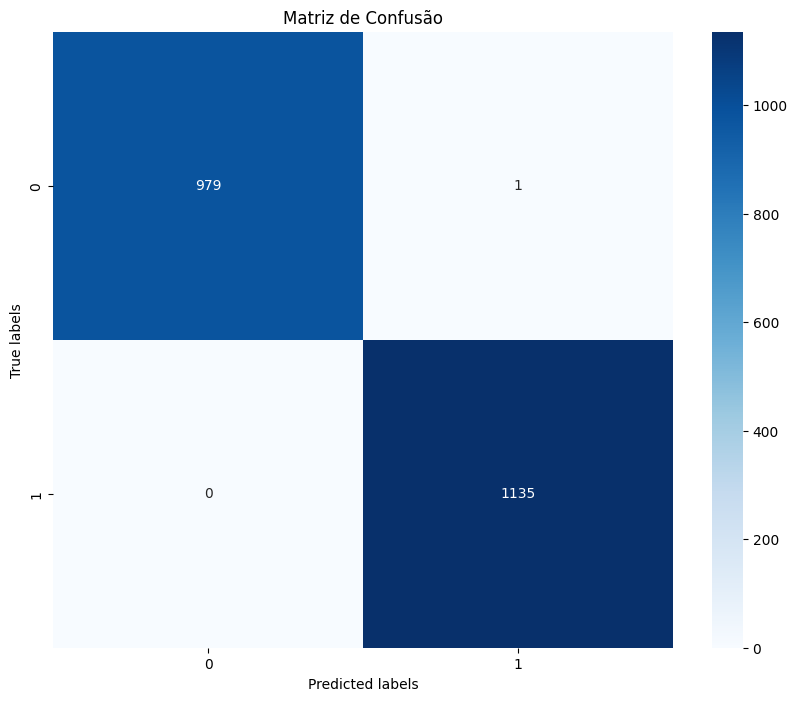

In [11]:
# Previsões
classes_previstas = np.argmax(saidas, axis=1)
classes_verdadeiras = np.argmax(y_test_binary, axis=1)

# Calcule a matriz de confusão
cm = confusion_matrix(classes_verdadeiras, classes_previstas)

# Plot a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusão')
plt.show()

Testar o modelo

In [12]:
test_loss, test_acc = model.evaluate(x_test_binary, y_test_binary)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.5172e-04
Test accuracy: 0.9995272159576416, Test loss: 0.001143776229582727
